In [199]:
import pandas as pd
import numpy as np
from datetime import datetime
from nltk.corpus import stopwords
import nltk
import string
from itertools import combinations, product
from scipy.special import softmax
from sklearn import preprocessing
import seaborn as sns; sns.set_theme()
import glob
from sklearn.preprocessing import StandardScaler, maxabs_scale
import matplotlib.pyplot as plt

# 
from scipy.sparse.csgraph import minimum_spanning_tree
from pykalman import KalmanFilter
from pandas_datareader import data as web

from numpy.linalg import inv

In [2]:
file_name = '../data/TRNA_V4.news.2006.csv'
news_2006 = pd.read_csv(file_name, sep = ",", header = 0, index_col = ['sourceTimestamp'], engine='c') 	
news_2006.columns

Index(['Unnamed: 0', 'amerTimestamp', 'apacTimestamp', 'emeaTimestamp', 'id',
       'dataType', 'feedFamilyCode', 'headline', 'language', 'altId',
       'feedTimestamp', 'isArchive', 'audiences', 'firstCreated',
       'instancesOf', 'takeSequence', 'provider', 'sourceId', 'subjects',
       'urgency', 'bodySize', 'companyCount', 'exchangeAction', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'systemVersion'],
      dtype='object')

In [3]:
news_2006.shape

(1708641, 28)

In [4]:
# target news ticker columns
subset = ['subjects']
news_tickers = news_2006[subset]
news_tickers.head()

subjects
sourceTimestamp                                                       
2005-12-31 21:00:05  N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:00:05  N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:00:05  N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:43:32  N2:IN N2:ASIA N2:EMRG N2:DIP N2:VIO N2:POL N2:...
2005-12-31 21:43:32  N2:IN N2:ASIA N2:EMRG N2:DIP N2:VIO N2:POL N2:...

In [5]:
news_tickers.head().to_latex('../output/news_data_subject_sample.tex')

** Set date time as index**

In [5]:
# specify date format
date_format = '%Y-%m-%d %H:%M:%S' # Y for year, m for month, d for day

# convert each string in date column to date object, x is a string
news_tickers.index = [datetime.strptime(x, date_format) for x in news_tickers.index]

**Tokenization**

In [6]:
def tokenize(doc):
    # tokenization to unigrams
    pattern = r'\w[\w\',-]*\w'                        
    tokens = nltk.regexp_tokenize(doc, pattern)

    # convert to lowwer case
    tokens = [token.lower() for token in tokens]

    # drop stop words
    tokens = [token for token in tokens if token in ticker_subset]
    return tokens

In [7]:
# load tickers list
file_path = '../data/'
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]

ticker_subset = tickers_info.index.values
ticker_subset = [x.lower() for x in ticker_subset]

In [8]:
news_tickers['clean_tickers'] = news_tickers['subjects'].apply(tokenize)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
news_tickers.head().to_latex('../output/news_data_tokenization_sample.tex')

# 2. Ticker Pair Construct and Count

**Cartesian Product to  generate every possible combination of ticker pairs**

In [10]:
ticker_pairs = list(product(ticker_subset, ticker_subset))

**Convert Unigram to Ticker Pair**

In [11]:
pair_construct = lambda tickers: list(combinations(tickers,2))
news_tickers['ticker_pair'] = news_tickers['clean_tickers'].apply(pair_construct)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
news_tickers['ticker_pair'].head(100)

2005-12-31 21:00:05               []
2005-12-31 21:00:05               []
2005-12-31 21:00:05               []
2005-12-31 21:43:32    [(intc, ibm)]
2005-12-31 21:43:32    [(intc, ibm)]
                           ...      
2006-01-01 12:47:32               []
2006-01-01 12:52:33               []
2006-01-01 12:52:33               []
2006-01-01 13:54:46               []
2006-01-01 13:54:46               []
Name: ticker_pair, Length: 100, dtype: object

In [16]:
news_tickers.iloc[1245: 1250].to_latex('../output/news_ticker_pairs_sample.tex')

**Count ticker pair for each news observation**

In [13]:
ticker_pairs_dictionary = dict(zip(ticker_pairs, [0] * len(ticker_pairs)))

In [14]:
def ticker_pair_count(subject_ticker_pairs):
    if subject_ticker_pairs == []:
        return 
    for x in subject_ticker_pairs:
        if x in ticker_pairs:
            ticker_pairs_dictionary[x] += 1

In [15]:
news_tickers['ticker_pair'].apply(ticker_pair_count)

2005-12-31 21:00:05    None
2005-12-31 21:00:05    None
2005-12-31 21:00:05    None
2005-12-31 21:43:32    None
2005-12-31 21:43:32    None
                       ... 
2006-12-31 16:13:43    None
2006-12-31 16:13:43    None
2006-12-31 16:13:43    None
2006-12-31 16:59:34    None
2006-12-31 18:03:36    None
Name: ticker_pair, Length: 1708641, dtype: object

In [16]:
ticker_pairs_dictionary = {(key, key2):[value] for (key, key2), value in ticker_pairs_dictionary.items()}

In [39]:
news_correlation.stack().head().to_latex('../output/news_ticker_pairs_count.tex')

# 3. Transformation and Standarization

**Convert ticker pairs to correlation matrix**

In [17]:
# correlation matrix
news_correlation = pd.DataFrame(ticker_pairs_dictionary, index = [0]).T.unstack(level=-1).T

# make it positive definite
column_names = news_correlation.columns.str.upper()
news_correlation = pd.DataFrame(news_correlation.values.T + news_correlation.values)
news_correlation.index = column_names
news_correlation.columns = column_names

# modify the diagnoal item
np.fill_diagonal(news_correlation.values, news_correlation.apply(sum, axis=0))

# overview
news_correlation

AAPL  AMGN  AXP     BA   CAT  CRM  CSCO  CVX   DIS  DOW  ...   MRK  \
AAPL  5748     5   14    132   265    6    98   18   415    0  ...    70   
AMGN     5   585   32      0    27    0     3    0     0    5  ...    95   
AXP     14    32  868      0     0    0     5    0     2    0  ...    14   
BA     132     0    0  10909   211    0   172  155   150    7  ...    51   
CAT    265    27    0    211  1566    0    81    0     5    7  ...    11   
CRM      6     0    0      0     0  362    16    0     0    0  ...    12   
CSCO    98     3    5    172    81   16  1738    9   159    0  ...    32   
CVX     18     0    0    155     0    0     9  514    33    0  ...    14   
DIS    415     0    2    150     5    0   159   33  2212   15  ...   304   
DOW      0     5    0      7     7    0     0    0    15  145  ...     0   
GS     105     0  310    251    16    0    31   46    50    7  ...    17   
HD     133    24   13     75    80    0    11    0    15    7  ...    24   
HON     32     5    0    232   118    0     0    0    18   14  ...    21   
IBM    452     6    0    112    69   87   168   25     5    0  ...    34   
INTC  1006    31    9    330   256   15   178   91    81    0  ...    56   
JNJ     82   251   12     48    13    0    38    0    20    0  ...   195   
JPM    180     0  180     65    12    0    11    0     8    0  ...     0   
KO     223     0   65     19    16    0    29    0   122   11  ...    28   
MCD    107     0    5     54    32    0     0    0    35    0  ...    35   
MMM    111    10   12    151    83    0    40    0     9   19  ...   123   
MRK     70    95   14     51    11   12    32   14   304    0  ...  1699   
MSFT  1604    46   67    376   137  214   379   20   293   18  ...    37   
NKE     57     0   41      0     0    0     0    5    15    0  ...    12   
PG      94     0   32     35    33    0    26   10    74    7  ...   120   
TRV      0     0    0      0     0    0     0    0     0    0  ...     0   
UNH     52    13    0     36     0    0     5   14    10    0  ...    98   
V        0     0    0      0     0    0     0    0     0    0  ...     0   
VZ      86     0    0     61    37    0   206    9   221    0  ...    82   
WBA      0     0    0      0     0    0     0    0     0    0  ...     0   
WMT    401     0   49    628    47    0    35   59   133   28  ...   106   

      MSFT  NKE    PG  TRV  UNH  V    VZ  WBA   WMT  
AAPL  1604   57    94    0   52  0    86    0   401  
AMGN    46    0     0    0   13  0     0    0     0  
AXP     67   41    32    0    0  0     0    0    49  
BA     376    0    35    0   36  0    61    0   628  
CAT    137    0    33    0    0  0    37    0    47  
CRM    214    0     0    0    0  0     0    0     0  
CSCO   379    0    26    0    5  0   206    0    35  
CVX     20    5    10    0   14  0     9    0    59  
DIS    293   15    74    0   10  0   221    0   133  
DOW     18    0     7    0    0  0     0    0    28  
GS      69    0   193    0    0  0    41    0   254  
HD      89   11     8    0   57  0    12    0   801  
HON     50    0    36    0    0  0     0    0    32  
IBM   1079   10    68    0   62  0    22    0    84  
INTC   885   16   183    0    0  0    58    0   188  
JNJ     39    0   167    0   61  0    19    0   148  
JPM     97   10     5    0   50  0    10    0   113  
KO     147   85   183    0    0  0     7    0   212  
MCD     21    0    24    0   10  0     0    0    48  
MMM     26    0    33    0    0  0     0    0    38  
MRK     37   12   120    0   98  0    82    0   106  
MSFT  6747   75   227    0   32  0   345    0   321  
NKE     75  437     7    0    9  0     0    0    84  
PG     227    7  1978    0   14  0    89    0   286  
TRV      0    0     0    0    0  0     0    0     0  
UNH     32    9    14    0  579  0    18    0    38  
V        0    0     0    0    0  0     0    0     0  
VZ     345    0    89    0   18  0  1510    0   187  
WBA      0    0     0    0    0  0     0    0     0  
WMT    321   84   286    0   

In [19]:
news_correlation.to_csv('../output/data/outnews_correlation_2006.csv')

In [52]:
news_correlation.iloc[0:10,0:10].round(3).to_latex('../output/news_frequency_matrix.tex')

In [29]:
news_correlation = pd.read_csv('../output/data/outnews_correlation_2006.csv', index_col= 0, header= 0)

**Standarize count number to \[0,1\] (frequency)**

In [51]:
np.set_printoptions(precision=10)
sample_size = len(news_2006)
#news_correlation_frequency = news_correlation / np.diag(news_correlation)
news_correlation_frequency = news_correlation / sample_size
news_correlation_frequency = news_correlation_frequency.fillna(0)

# re-scale to leverage
news_correlation_frequency *= 100

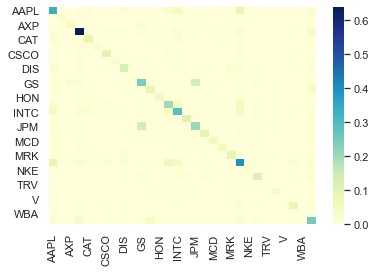

In [53]:
ax = sns.heatmap(news_correlation_frequency, cmap="YlGnBu")

In [54]:
news_correlation_frequency

AAPL      AMGN       AXP        BA       CAT       CRM      CSCO  \
AAPL  0.336408  0.000293  0.000819  0.007725  0.015509  0.000351  0.005736   
AMGN  0.000293  0.034238  0.001873  0.000000  0.001580  0.000000  0.000176   
AXP   0.000819  0.001873  0.050801  0.000000  0.000000  0.000000  0.000293   
BA    0.007725  0.000000  0.000000  0.638461  0.012349  0.000000  0.010066   
CAT   0.015509  0.001580  0.000000  0.012349  0.091652  0.000000  0.004741   
CRM   0.000351  0.000000  0.000000  0.000000  0.000000  0.021186  0.000936   
CSCO  0.005736  0.000176  0.000293  0.010066  0.004741  0.000936  0.101718   
CVX   0.001053  0.000000  0.000000  0.009072  0.000000  0.000000  0.000527   
DIS   0.024288  0.000000  0.000117  0.008779  0.000293  0.000000  0.009306   
DOW   0.000000  0.000293  0.000000  0.000410  0.000410  0.000000  0.000000   
GS    0.006145  0.000000  0.018143  0.014690  0.000936  0.000000  0.001814   
HD    0.007784  0.001405  0.000761  0.004389  0.004682  0.000000  0.000644   
HON   0.001873  0.000293  0.000000  0.013578  0.006906  0.000000  0.000000   
IBM   0.026454  0.000351  0.000000  0.006555  0.004038  0.005092  0.009832   
INTC  0.058877  0.001814  0.000527  0.019314  0.014983  0.000878  0.010418   
JNJ   0.004799  0.014690  0.000702  0.002809  0.000761  0.000000  0.002224   
JPM   0.010535  0.000000  0.010535  0.003804  0.000702  0.000000  0.000644   
KO    0.013051  0.000000  0.003804  0.001112  0.000936  0.000000  0.001697   
MCD   0.006262  0.000000  0.000293  0.003160  0.001873  0.000000  0.000000   
MMM   0.006496  0.000585  0.000702  0.008837  0.004858  0.000000  0.002341   
MRK   0.004097  0.005560  0.000819  0.002985  0.000644  0.000702  0.001873   
MSFT  0.093876  0.002692  0.003921  0.022006  0.008018  0.012525  0.022181   
NKE   0.003336  0.000000  0.002400  0.000000  0.000000  0.000000  0.000000   
PG    0.005501  0.000000  0.001873  0.002048  0.001931  0.000000  0.001522   
TRV   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
UNH   0.003043  0.000761  0.000000  0.002107  0.000000  0.000000  0.000293   
V     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VZ    0.005033  0.000000  0.000000  0.003570  0.002165  0.000000  0.012056   
WBA   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
WMT   0.023469  0.000000  0.002868  0.036754  0.002751  0.000000  0.002048   

           CVX       DIS       DOW  ...       MRK      MSFT       NKE  \
AAPL  0.001053  0.024288  0.000000  ...  0.004097  0.093876  0.003336   
AMGN  0.000000  0.000000  0.000293  ...  0.005560  0.002692  0.000000   
AXP   0.000000  0.000117  0.000000  ...  0.000819  0.003921  0.002400   
BA    0.009072  0.008779  0.000410  ...  0.002985  0.022006  0.000000   
CAT   0.000000  0.000293  0.000410  ...  0.000644  0.008018  0.000000   
CRM   0.000000  0.000000  0.000000  ...  0.000702  0.012525  0.000000   
CSCO  0.000527  0.009306  0.000000  ...  0.001873  0.022181  0.000000   
CVX   0.030082  0.001931  0.000000  ...  0.000819  0.001171  0.000293   
DIS   0.001931  0.129460  0.000878  ...  0.017792  0.017148  0.000878   
DOW   0.000000  0.000878  0.008486  ...  0.000000  0.001053  0.000000   
GS    0.002692  0.002926  0.000410  ...  0.000995  0.004038  0.000000   
HD    0.000000  0.000878  0.000410  ...  0.001405  0.005209  0.000644   
HON   0.000000  0.001053  0.000819  ...  0.001229  0.002926  0.000000   
IBM   0.001463  0.000293  0.000000  ...  0.001990  0.063150  0.000585   
INTC  0.005326  0.004741  0.000000  ...  0.003277  0.051796  0.000936   
JNJ   0.000000  0.001171  0.000000  ...  0.011413  0.002283  0.000000   
JPM   0.000000  0.000468  0.000000  ...  0.000000  0.005677  0.000585   
KO    0.000000  0.007140  0.000644  ...  0.001639  0.008603  0.004975   
MCD   0.000000  0.002048  0.000000  ...  0.002048  0.001229  0.000000   
MMM   0.000000  0.000527  0.001112  ...  0.007199  0.001522  0.000000   
MRK   0.000819  0.017792  0.000000  ...  0.099436  0.00216

# 4. Information filtering

 Normalized PMI is the PMI divided by the upper bound:
   $$NPMI(w_1,w_2)=\frac{\log{\frac{p(w_1,w_2)}{p(w_1)*p(w_2)}}}{-\log{p(w_1,w_2)}}$$

In [77]:
def get_npmi(correlation_matrix):

    # initialize a container
    news_npmi = correlation_matrix.copy()

    # calculate npmi
    for w1 in correlation_matrix.index:
        for w2 in correlation_matrix.columns:
            p_w1_w2 = correlation_matrix.loc[w1][w2]
            p_w1 = correlation_matrix.loc[w1][w1]
            p_w2 = correlation_matrix.loc[w2][w2]
            npmi = np.log((p_w1_w2 / (p_w1 * p_w2))) / (- np.log(p_w1_w2))
            news_npmi.loc[w1][w2] = npmi

    # modification on NA
    news_npmi = news_npmi.fillna(0)
    
    return news_npmi


/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


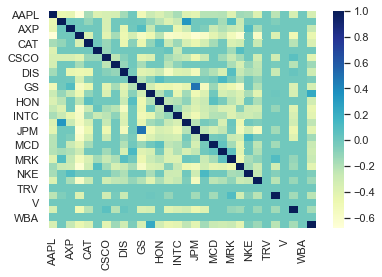

In [81]:
news_npmi = get_npmi(news_correlation_frequency)
ax = sns.heatmap(news_npmi, cmap="YlGnBu")

# 5. Minimum Spanning Tree

In [92]:
def get_minimum_spanning_tree(correlation_matrix):

    # convert correlation to distance
    get_distance_i_j = lambda rho, p = 2: np.sqrt(1 - abs(rho ** p))
    distance_matrix = correlation_matrix.apply(get_distance_i_j, args=[2])

    # construct MST 
    MST = minimum_spanning_tree(distance_matrix)
    MST = MST.toarray().astype(float)

    # make it positive defninete
    MST = np.maximum(MST, MST.transpose())
    np.fill_diagonal(MST, 1)

    # make dataframe
    MST = pd.DataFrame(MST, index=correlation_matrix.index, columns=correlation_matrix.columns)

    return MST

In [190]:
MST_news_2006 = get_minimum_spanning_tree(news_npmi)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 6. Kalman filter

Kalman filter can be used to combine informantion to achieve better esitmation. Here, we use it to combine correlation from news and stock estimation.

In [185]:
def get_stocks_returns(stocks, start_date, end_date):
  df = web.DataReader(stocks, data_source='yahoo', start = start_date, end= end_date )['Close']
  df = pd.DataFrame(df)
  returns = df.pct_change().dropna() * 252
  returns['V'] = np.zeros(len(returns))
  returns['DOW'] = np.zeros(len(returns))
  return returns

In [186]:
# get target group
tickers_subset = news_correlation.index.values

# modification 
# tickers_subset = np.where(tickers_subset == 'DOW', 'DJIA', tickers_subset)
tickers_subset = tickers_subset.tolist()
tickers_subset.remove('V')
tickers_subset.remove('DOW')

In [187]:
# get stock returns (annualized)
stocks_returns_2006 = get_stocks_returns(tickers_subset, '2006-01-01', '2006-12-31')
stocks_returns_2007 = get_stocks_returns(tickers_subset, '2007-01-01', '2007-12-31')

# get correlation and volatility
stocks_correlation_2006 = stocks_returns_2006.corr()
stocks_correlation_2007 = stocks_returns_2007.corr()

stocks_vol_2006 = stocks_returns_2006.std()
stocks_vol_2007 = stocks_returns_2007.std()

# avoid singular matrix
stocks_vol_2006['V'] = 1
stocks_vol_2006['DOW'] = 1

In [224]:
# load market data
file_name = 'F-F_Research_Data_Factors_daily.csv'
interest_rate = pd.read_csv(file_path + file_name,  header=0, usecols=[0, 4], index_col=[0], engine='c').dropna()
date_format = '%Y%m%d' # Y for year, m for month, d for day
rf_date = pd.Index([datetime.strptime(str(x), date_format) for x in interest_rate.index])
interest_rate.index = rf_date

In [189]:
# perform MST on stock correlation
MST_stock_2006 = get_minimum_spanning_tree(stocks_correlation_2006)

In [194]:
# kalman filter function combine two matrix
def get_kalman_combination(m1, m2):

    kalman = m1.copy()
    for i in range(len(kalman.index)):
        for j in range(len(kalman.columns)):
            kalman.values[i][j] = 1 / ((1 / m1.values[i][j]) + (1 / m2.values[i][j]))

    np.fill_diagonal(kalman.values, 1)

    return kalman

In [226]:
kalman_2006 = get_kalman_combination(MST_stock_2006, MST_news_2006)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


# 7. Peformance evaluation

In [196]:
def get_GMVP(correlated_matrix, volatility_vector):
    # initialization
    R_1 = correlated_matrix.values
    D = np.diag(volatility_vector) 
    one = np.ones(D.shape[0])

    # cov calculation
    H = D @ R_1 @ D 

    # pre calculation
    H_inv = inv(H)
    numerator = H_inv @ one
    denominator = one.T @ H_inv @ one

    # GMV porfolio
    x = numerator / denominator

    #return pd.DataFrame(H)
    return x.reshape((len(x), 1))

In [217]:
def sharpe_ratio(stock_return):
    '''Given portfolio daily returns to calculate Sharpe ratio

    Argument:
        stock_return: a matrix that each column reperents a time series given specific portfolio
    Requirement:
        interest_rate matrix as risk free rate
    Return:
        pd.DataFrame (N x 1)

    '''

    # initialization
    date_idx = stock_return.index
    r_f = interest_rate.loc[date_idx].values.flatten()
    alpha_range = stock_return.shape[1] # changed from return_series.shape[1]
    sharpe_ratio_series = {} # SR container

    for i in np.arange(0, alpha_range):

        # initialization
        return_list = stock_return.iloc[:,i]
        alpha = return_list.name
        
        # calculate annual SR
        excess_return = return_list - r_f * 0.01
        expected_return = excess_return.mean() * 252
        volatility = excess_return.std()* np.sqrt(252)
        sharpe_ratio = expected_return / volatility
        
        # store SR
        sharpe_ratio_series[alpha] = sharpe_ratio

    temp = pd.DataFrame(sharpe_ratio_series, index=['SR']).T
    
    return temp

In [236]:
# avoid singular matrix
news_correlation_frequency['V']['V'] = 1
news_correlation_frequency['WBA']['WBA'] = 1
news_correlation_frequency['TRV']['TRV'] = 1

news_npmi['V']['V'] = 1
news_npmi['WBA']['WBA'] = 1
news_npmi['TRV']['TRV'] = 1

stocks_correlation_2006 = stocks_correlation_2006.fillna(0)
stocks_correlation_2006['V']['V'] = 1
stocks_correlation_2006['DOW']['DOW'] = 1

In [277]:
GMVP_stock = get_GMVP(stocks_correlation_2006, stocks_vol_2006)
GMVP_news = get_GMVP(news_correlation_frequency, stocks_vol_2006)
GMVP_news_npmi = get_GMVP(news_npmi, stocks_vol_2006)
GMVP_MST_news = get_GMVP(MST_news_2006, stocks_vol_2006)
GMVP_MST_stock = get_GMVP(MST_stock_2006, stocks_vol_2006)
GMVP_kalman = get_GMVP(kalman_2006, stocks_vol_2006)

In [278]:
portfolios = np.concatenate((GMVP_stock, GMVP_news, GMVP_news_npmi, GMVP_MST_news, GMVP_MST_stock, GMVP_kalman), axis = 1)

In [284]:
R_p = (portfolios.T @ stocks_returns_2007.T).T

In [222]:
daily_returns_2007 = stocks_returns_2007 @ GMVP_MST_stock

In [286]:
SR = sharpe_ratio(R_p)
SR.index = ['Stock', 'News frequency', 'News NPMI', 'News MST', 'stock MST', 'Kalman filter']
SR

SR
Stock           0.790906
News frequency  0.696912
News NPMI       1.499143
News MST       -1.593202
stock MST       0.361674
Kalman filter   0.712147

In [310]:
SR.to_latex('/Users/cheng/Dropbox/Apps/Overleaf/BIA 660 Project Proposal/table/performance.tex')

# 8. Comparison between different correlation matrix

In [301]:
def heatmap_compare_of_two(matrix_1, matrix_2, y_label, x_label, subtitle_1, subtitle_2, file_name):

    # heat map compare
    fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True, figsize = (26, 13))
    im1 = ax1.imshow(matrix_1)
    im2 = ax2.imshow(matrix_2)

    #show all ticks...
    ax1.set_xticks(np.arange(len(x_label)))
    ax1.set_yticks(np.arange(len(y_label)))
    ax1.set_xticklabels(x_label)
    ax1.set_yticklabels(y_label)

    ax2.set_xticks(np.arange(len(x_label)))
    ax2.set_yticks(np.arange(len(y_label)))
    ax2.set_xticklabels(x_label)
    ax2.set_yticklabels(y_label)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(name_list)):
        for j in range(len(name_list)):
            text1 = ax1.text(j, i, round(matrix_1[i, j], 2),
                        ha="center", va="center", color="w")
            text2 = ax2.text(j, i, round(matrix_2[i, j], 2),
                        ha="center", va="center", color="w")

    ax1.set_title(subtitle_1)
    ax2.set_title(subtitle_2)
    fig.tight_layout()
    plt.savefig('/Users/cheng/Dropbox/Apps/Overleaf/BIA 660 Project Proposal/picture/' + file_name + '.png')
    plt.show()
    

In [290]:
name_list = news_npmi.columns.to_list()

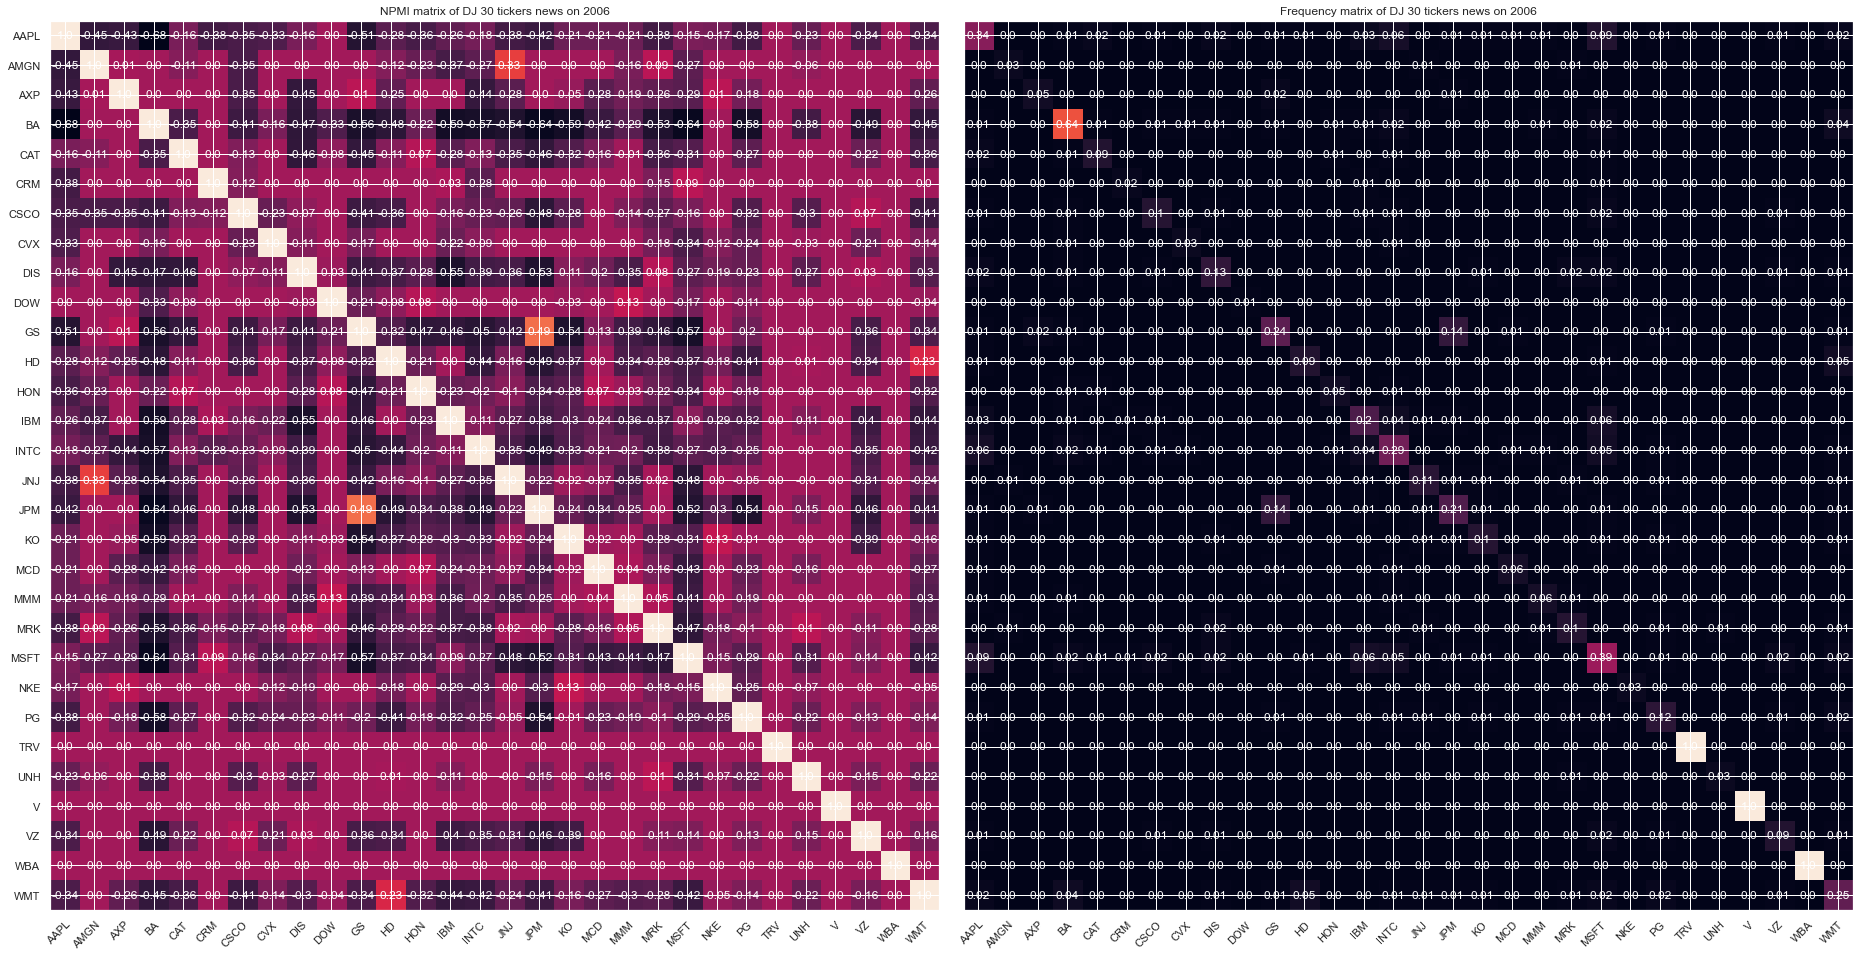

In [302]:
parameters = {'matrix_1' : news_npmi.round(2).values,
              'matrix_2' : news_correlation_frequency.round(2).values,
              'x_label': name_list,
              'y_label' : name_list,
              'subtitle_1': "NPMI matrix of DJ 30 tickers news on 2006",
              'subtitle_2' : "Frequency matrix of DJ 30 tickers news on 2006",
              'file_name' : 'Comparison of NPMI and frequency matrix on 2006'}
heatmap_compare_of_two(**parameters)

In [303]:
news_npmi.iloc[0:10,0:10].round(3).to_latex('/Users/cheng/Dropbox/Apps/Overleaf/BIA 660 Project Proposal/table/news_npmi_matrix.tex')

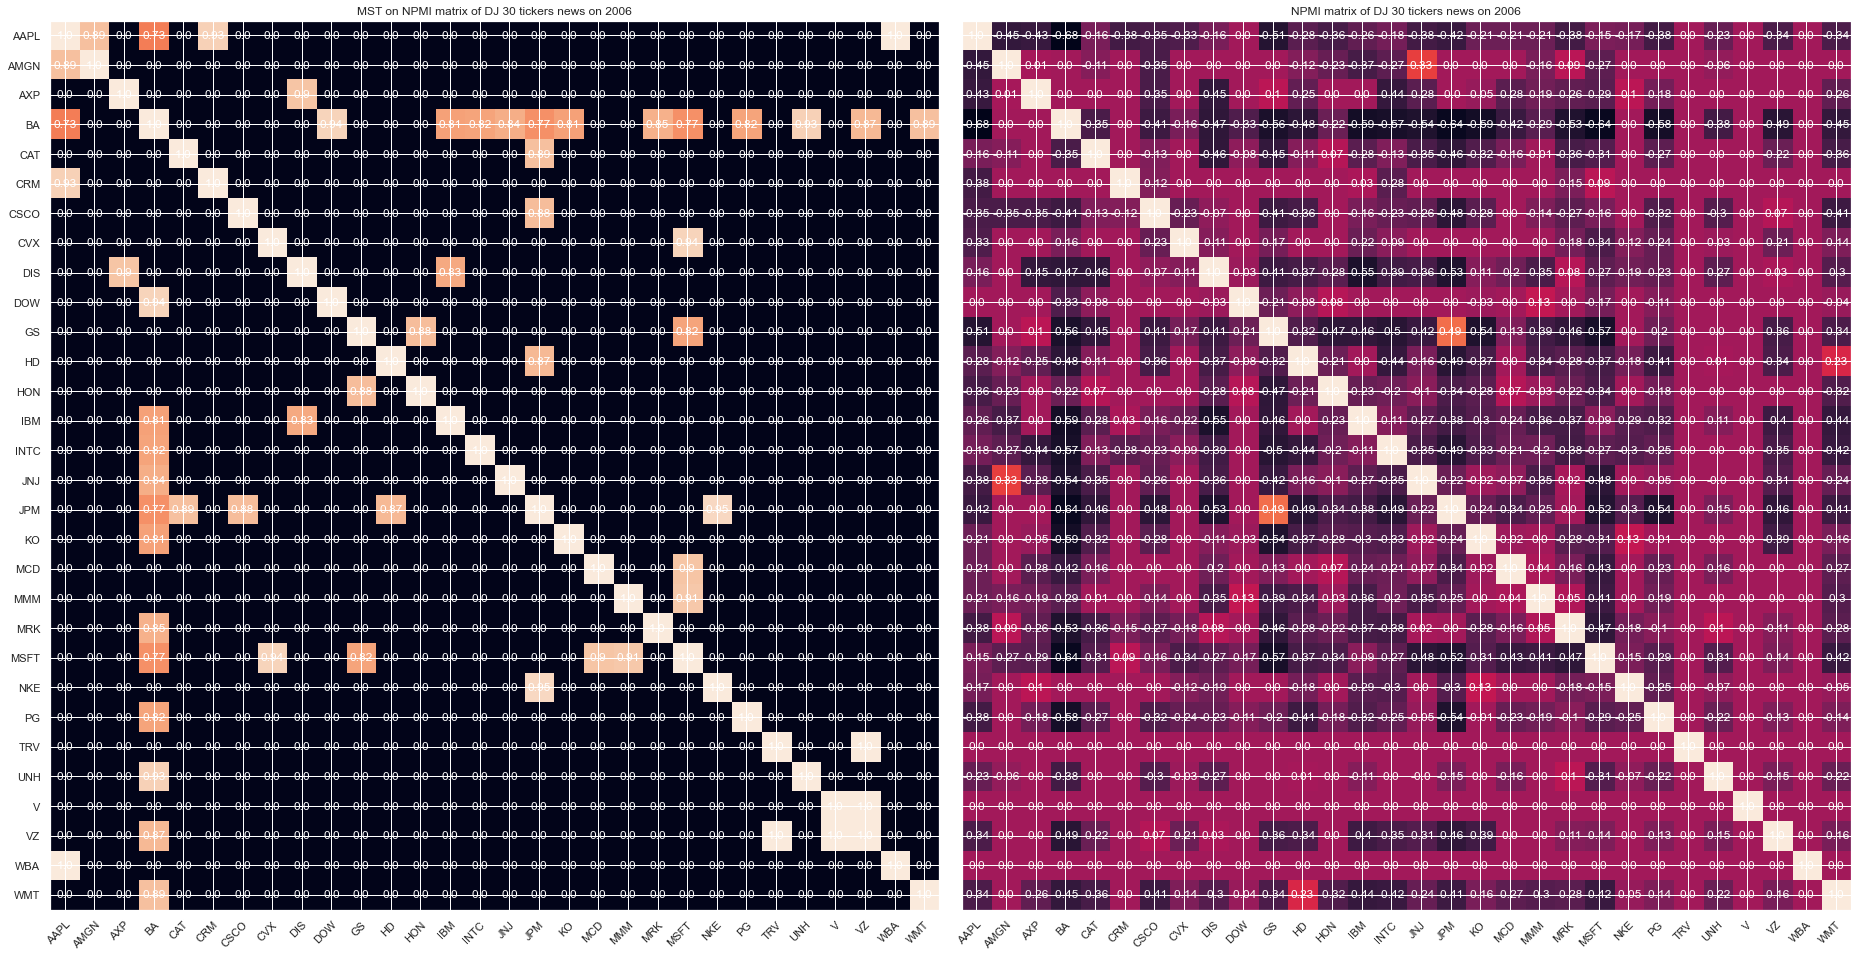

In [305]:
parameters = {'matrix_1' : MST_news_2006.round(2).values,
              'matrix_2' : news_npmi.round(2).values,
              'x_label': name_list,
              'y_label' : name_list,
              'subtitle_1': "MST on NPMI matrix of DJ 30 tickers news on 2006",
              'subtitle_2' : "NPMI matrix of DJ 30 tickers news on 2006",
              'file_name' : 'Comparison of MST and NPMI matrix on 2006'}
heatmap_compare_of_two(**parameters)

In [306]:
MST_news_2006.iloc[0:10,0:10].round(3).to_latex('/Users/cheng/Dropbox/Apps/Overleaf/BIA 660 Project Proposal/table/news_MST_matrix.tex')

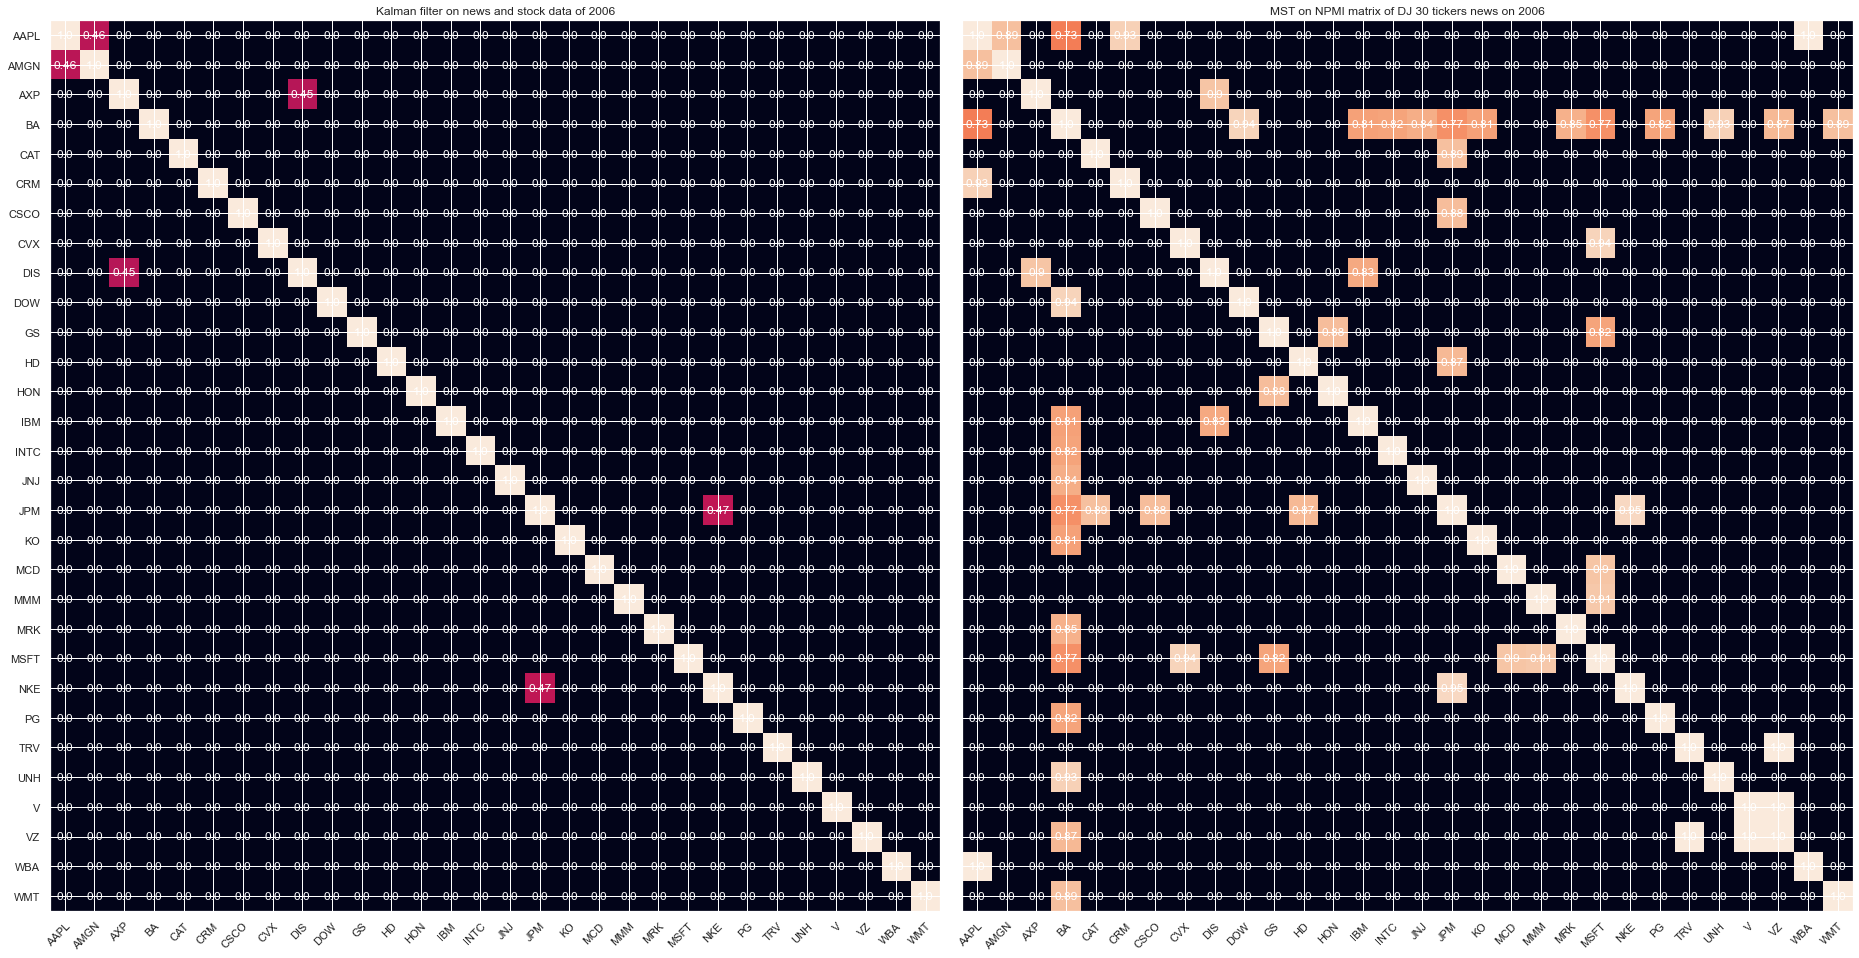

In [307]:
parameters = {'matrix_1' : kalman_2006.round(2).values,
              'matrix_2' : MST_news_2006.round(2).values,
              'x_label': name_list,
              'y_label' : name_list,
              'subtitle_1': "Kalman filter on news and stock data of 2006",
              'subtitle_2' : "MST on NPMI matrix of DJ 30 tickers news on 2006",
              'file_name' : 'Comparison of Kalman and MST matrix on 2006'}
heatmap_compare_of_two(**parameters)

In [308]:
kalman_2006.iloc[0:10,0:10].round(3).to_latex('/Users/cheng/Dropbox/Apps/Overleaf/BIA 660 Project Proposal/table/kalman.tex')

In [115]:
file_path = '../data/'
# load TBN tickers
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]


# load stock data
file_name = 'stock_data.csv'
stock_data = pd.read_csv(file_path + file_name,  header=0, index_col=[0], engine='c')
tickers_subset = stock_data.dropna(axis='columns').columns
tickers_key = tickers_info.loc[tickers_subset].gvkey.values


In [116]:
# Na value
stock_data = stock_data.dropna(axis='columns') # drop incomplete data to form 26 columns

# set year as index 
date_format = '%Y-%m-%d' # Y for year, m for month, d for day
stock_date = pd.Index([datetime.strptime(x, date_format) for x in stock_data.index])
stock_data.index = [x.year for x in stock_date]

# calculate stock returns
stock_returns = stock_data.pct_change().dropna(axis='rows')

# correlation for stock return
correlation_aggregate = stock_returns.groupby(level=0).corr()
volatility_aggregate = stock_returns.groupby(level=0).std()
covariance_aggregate = stock_returns.groupby(level=0).cov()

# modification
correlation_return_2006 = correlation_aggregate.loc[2006]
#np.fill_diagonal(correlation_return_2006.values, 0)

Text(0.5, 1.0, 'TBN Scaled')

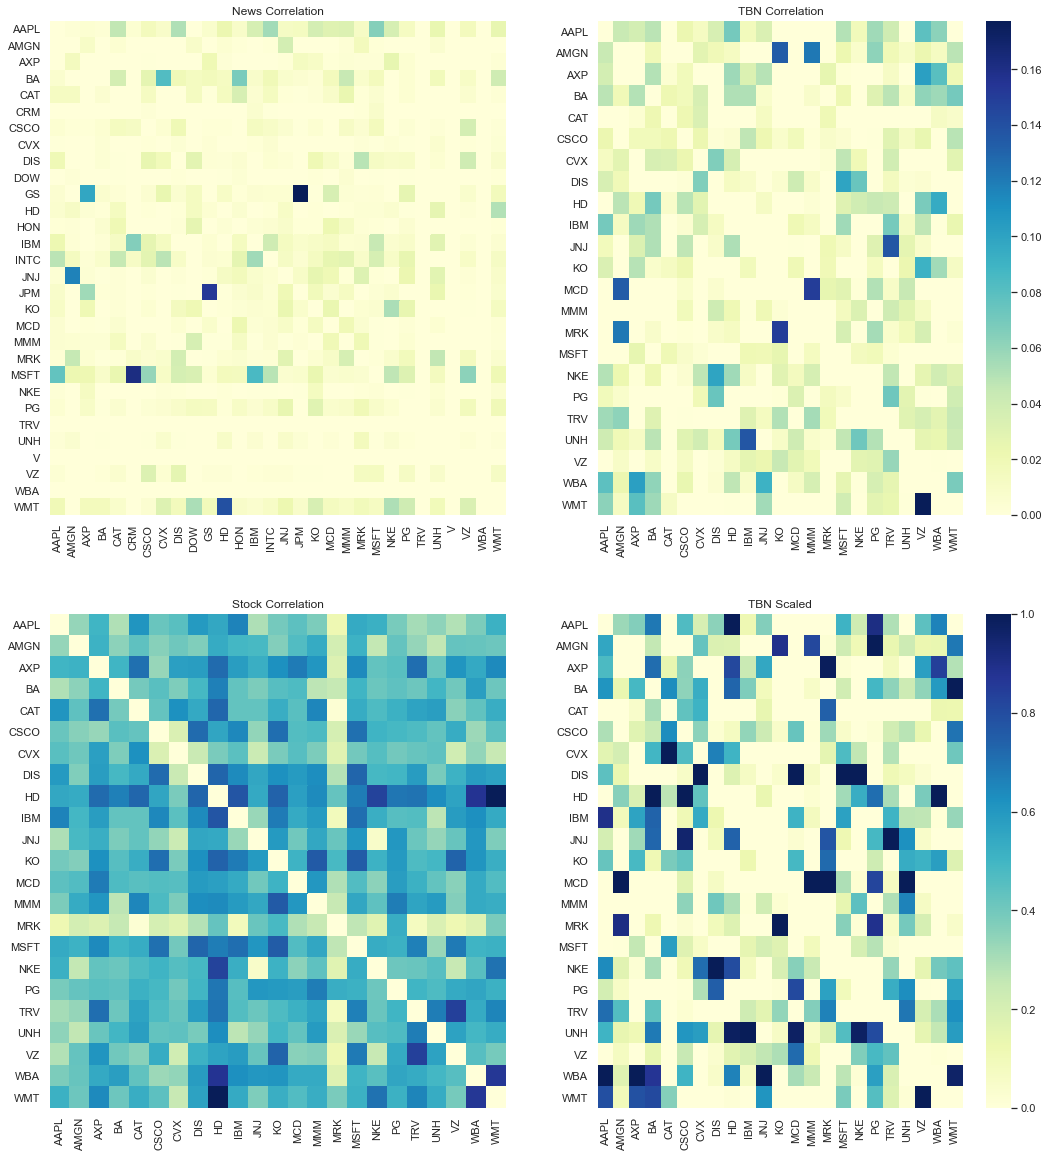

In [92]:
f,((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2,sharey=False, figsize=(18, 20))

g1 = sns.heatmap(news_correlation,cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('News Correlation')

g2 = sns.heatmap(correlation_text_2006, cmap="YlGnBu",ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_title('TBN Correlation')

g3 = sns.heatmap(correlation_return_2006,cmap="YlGnBu",cbar=False,ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_title('Stock Correlation')

g4 = sns.heatmap(scaled_tbn_2005, cmap="YlGnBu",ax=ax4)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_title('TBN Scaled')

In [97]:
f.savefig('../picture/matrix_compare_2.png')

Text(0.5, 1.0, 'TBN Correlation')

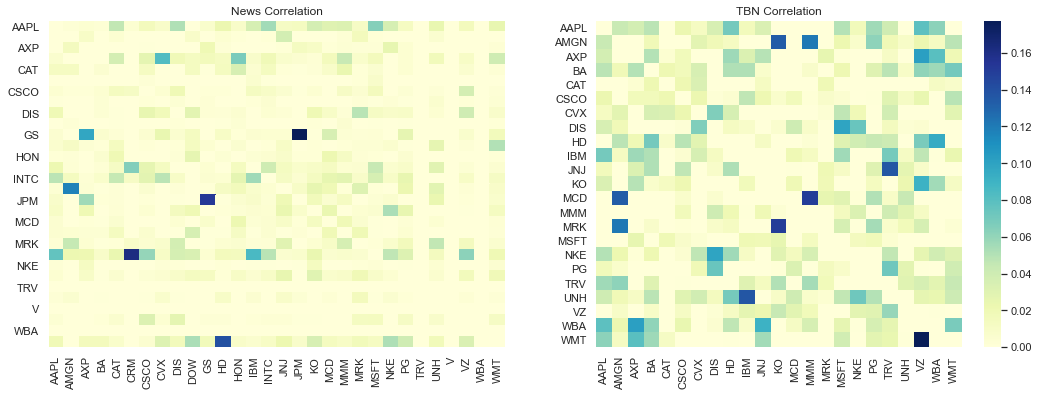

In [94]:
f,(ax1,ax2) = plt.subplots(1,2,sharey=False, figsize=(18, 6))

g1 = sns.heatmap(news_correlation,cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('News Correlation')

g2 = sns.heatmap(correlation_text_2006, cmap="YlGnBu",ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_title('TBN Correlation')

Text(0.5, 1.0, 'TBN Scaled')

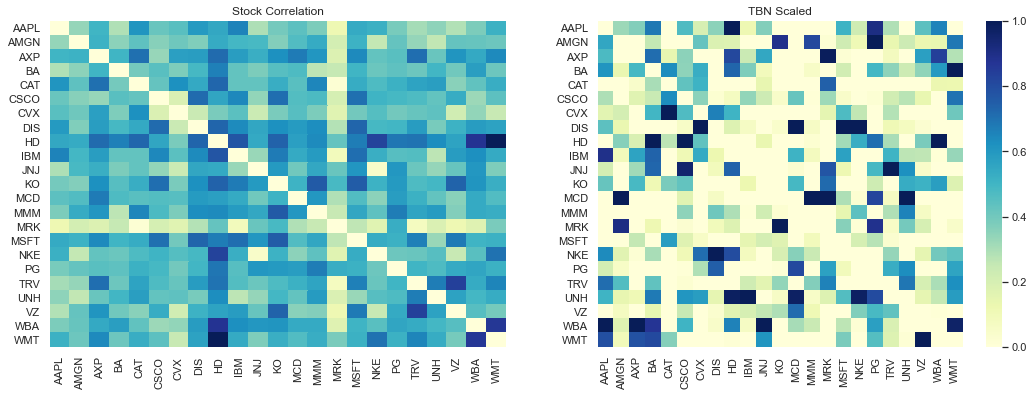

In [96]:
f,(ax3, ax4) = plt.subplots(1,2,sharey=False, figsize=(18, 6))

g3 = sns.heatmap(correlation_return_2006,cmap="YlGnBu",cbar=False,ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_title('Stock Correlation')

g4 = sns.heatmap(scaled_tbn_2005, cmap="YlGnBu",ax=ax4)
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_title('TBN Scaled')

In [26]:
p_w

AAPL    3.139422
AMGN    1.300007
AXP     1.392831
BA      2.063775
CAT     1.677179
CRM     1.044101
CSCO    1.650079
CVX     1.134081
DIS     2.022481
DOW     1.081077
GS      2.671333
HD      1.642234
HON     1.476215
IBM     2.296353
INTC    2.775446
JNJ     2.210112
JPM     2.248718
KO      1.909986
MCD     1.427539
MMM     1.538511
MRK     2.052239
MSFT    4.126205
NKE     1.197511
PG      1.862879
TRV     0.000000
UNH     1.292873
V       0.000000
VZ      1.552128
WBA     0.000000
WMT     3.240891
dtype: float64

AAPL      AMGN       AXP        BA       CAT       CRM      CSCO  \
AAPL  1.000000  0.009417  0.018565  0.035065  0.215324  0.017618  0.073436   
AMGN  0.009417  1.000000  0.091567  0.000000  0.063395  0.000000  0.006854   
AXP   0.018565  0.091567  1.000000  0.000000  0.000000  0.000000  0.008637   
BA    0.035065  0.000000  0.000000  1.000000  0.154080  0.000000  0.114731   
CAT   0.215324  0.063395  0.000000  0.154080  1.000000  0.000000  0.098329   
CRM   0.017618  0.000000  0.000000  0.000000  0.000000  1.000000  0.053405   
CSCO  0.073436  0.006854  0.008637  0.114731  0.098329  0.053405  1.000000   
CVX   0.038151  0.000000  0.000000  0.315765  0.000000  0.000000  0.022688   
DIS   0.259812  0.000000  0.003208  0.081562  0.005453  0.000000  0.163365   
DOW   0.000000  0.043030  0.000000  0.048918  0.052746  0.000000  0.000000   
GS    0.043642  0.000000  0.432058  0.083666  0.014084  0.000000  0.025328   
HD    0.108286  0.056391  0.023300  0.054890  0.102302  0.000000  0.013371   
HON   0.039976  0.013923  0.000000  0.270729  0.202233  0.000000  0.000000   
IBM   0.209423  0.011993  0.000000  0.042674  0.064027  0.265505  0.145274   
INTC  0.379323  0.059287  0.012196  0.097269  0.215464  0.044483  0.138566   
JNJ   0.059670  0.568041  0.020469  0.030978  0.015500  0.000000  0.042905   
JPM   0.081778  0.000000  0.257836  0.024181  0.011027  0.000000  0.009413   
KO    0.173053  0.000000  0.114018  0.013181  0.019850  0.000000  0.034145   
MCD   0.132445  0.000000  0.011080  0.062397  0.054477  0.000000  0.000000   
MMM   0.136771  0.027676  0.026523  0.173630  0.140832  0.000000  0.065343   
MRK   0.053379  0.218308  0.024369  0.034693  0.013499  0.040212  0.037247   
MSFT  0.516789  0.085450  0.087119  0.090195  0.107789  0.622878  0.274240   
NKE   0.140351  0.000000  0.141057  0.000000  0.000000  0.000000  0.000000   
PG    0.063876  0.000000  0.053044  0.020903  0.037756  0.000000  0.028104   
TRV   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
UNH   0.098857  0.044675  0.000000  0.065476  0.000000  0.000000  0.011512   
V     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VZ    0.071915  0.000000  0.000000  0.045989  0.048130  0.000000  0.254951   
WBA   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
WMT   0.162502  0.000000  0.067784  0.202803  0.040882  0.000000  0.028232   

           CVX       DIS       DOW  ...       MRK      MSFT       NKE  \
AAPL  0.038151  0.259812  0.000000  ...  0.053379  0.516789  0.140351   
AMGN  0.000000  0.000000  0.043030  ...  0.218308  0.085450  0.000000   
AXP   0.000000  0.003208  0.000000  ...  0.024369  0.087119  0.141057   
BA    0.315765  0.081562  0.048918  ...  0.034693  0.090195  0.000000   
CAT   0.000000  0.005453  0.052746  ...  0.013499  0.107789  0.000000   
CRM   0.000000  0.000000  0.000000  ...  0.040212  0.622878  0.000000   
CSCO  0.022688  0.163365  0.000000  ...  0.037247  0.274240  0.000000   
CVX   1.000000  0.079121  0.000000  ...  0.035477  0.041875  0.021169   
DIS   0.079121  1.000000  0.110229  ...  0.316361  0.175886  0.041106   
DOW   0.000000  0.110229  1.000000  ...  0.000000  0.126806  0.000000   
GS    0.100611  0.034687  0.049968  ...  0.014114  0.026901  0.000000   
HD    0.000000  0.016384  0.052757  ...  0.029491  0.070169  0.032214   
HON   0.000000  0.027492  0.111605  ...  0.034941  0.061174  0.000000   
IBM   0.055872  0.003707  0.000000  ...  0.029850  0.472134  0.025777   
INTC  0.195524  0.053068  0.000000  ...  0.044333  0.310901  0.039863   
JNJ   0.000000  0.020116  0.000000  ...  0.222747  0.027375  0.000000   
JPM   0.000000  0.005859  0.000000  ...  0.000000  0.041570  0.025687   
KO    0.000000  0.128603  0.082485  ...  0.033338  0.110288  0.245682   
MCD   0.000000  0.053057  0.000000  ...  0.057834  0.025453  0.000000   
MMM   0.000000  0.013593  0.151140  ...  0.202554  0.031367  0.000000   
MRK   0.035477  0.316361  0.000000  ...  1.000000  0.02726